# OMICS project 2021 | 1RepMax Team

### Authors: Amine Jalali, Michael Cen Feng, Hendrik Reitsma, Stylianos Mavrianos, Ruben Otter
### Version 1.0
### Date 27-01-2022

In [99]:
import seaborn as sns
import panel as pn
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from bokeh.plotting import figure, show
from datetime import datetime as dt
import time
import hvplot.pandas
import dateutil.parser
import numpy as np
import holoviews as hv
from scipy.ndimage import gaussian_filter1d
import json
import scipy.stats

In [100]:
class dataParsers:  #Ruben
    """
    Class with a function that parses datetime and returns dates
    """
    def datetimeparser(dates):
        """
        Function that parses datetime and returns dates
        """
        for i in range(len(dates)):
            dates[i] = dateutil.parser.isoparse(dates[i])
        return dates

In [101]:
class Subject:
    """
    Subject class that merges all dataframes per subject together
    
    """
    def __init__(self,name,age,gender):  #Ruben
        """
        Init function that assigns passed args to variables
        """
        self.name = name
        self.age = age
        self.gender = gender

    def importfiles(self):  #Ruben
        """
        Function that imports files as dataframes
        """
        filepath = 'organized_data/'+self.name.split(' ')[0]
        cronodf = pd.read_csv(filepath+'/cronometer.csv')
        selfdf = pd.read_excel(filepath+'/self_report.xlsx')            
        return cronodf, selfdf

    
    def create_sleep_df(self): #Amine
            """ This function reads sleep json and csv files and create separate 
            dataframes, cleans data, then merge dataframe and return it.
            """
            filepath = 'organized_data/'+self.name.split(' ')[0]
            ### Firstly, I read json file and clean data            
            with open(filepath + '/sleep.json') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            cd = pd.DataFrame()
            
            # delete related rows to nap
            cd['results'] = df[df.mainSleep == True].levels
            cd['results'] = cd.results.map(lambda x: str(x)[11:])
            cd.results = cd.results.astype("string")
            s = cd.results.str.rsplit("},", n=0,expand=True)
            # extract numbers of deep sleep
            df0 = s[0].str.extractall('(\d+)')[0].unstack().astype(float)
            # extract numbers of wake
            df1 = s[1].str.extractall('(\d+)')[0].unstack().astype(float)
            # extract numbers of light sleep
            df2 = s[2].str.extractall('(\d+)')[0].unstack().astype(float)
            # extract numbers of rem sleep
            df3 = s[3].str.extractall('(\d+)')[0].unstack().astype(float)
            
            cd[['deepcount', 'deepduration', 'deepthirtyDayAvg']] = df0[[0,1,2]]
            cd[['wakecount', 'wakeduration', 'wakethirtyDayAvg']] = df1[[0,1,2]]
            cd[['lightcount', 'lightduration', 'lightthirtyDayAvg']] = df2[[0,1,2]]
            cd[['remcount', 'remduration', 'remthirtyDayAvg']] = df3[[0,1,2]]
            
            cd['date'] = pd.to_datetime(df.endTime).dt.date
            cd.drop('results', inplace = True, axis = 1)
            cd.date = pd.to_datetime(cd.date)
            cd = cd[(cd.date > "2021-10-17") & (cd.date < "2021-12-14")]
            
            """some dates are duplicated, because json files are not generated 
            in one integrated file, and I merged them manually, so I delete them here"""
            cd = cd.drop_duplicates(subset=['date'])
            cd.drop(['deepthirtyDayAvg', "wakethirtyDayAvg", "lightthirtyDayAvg", "remthirtyDayAvg"],
                    inplace = True, axis = 1)
            
            
            ### Secondly, read sleep_score_csv file and make a dataframe.
            scoredf = pd.read_csv(filepath + "/sleep_score.csv")
            scoredf['date'] = pd.to_datetime(scoredf.timestamp).dt.date
            #drop unnecessary columns
            scoredf.drop(['sleep_log_entry_id', 'timestamp', 'timestamp', 'resting_heart_rate',
                          'composition_score', 'revitalization_score', 'duration_score', 'deep_sleep_in_minutes'],
                         inplace = True, axis = 1)
            
            scoredf.date = pd.to_datetime(scoredf.date)
            scoredf = scoredf[(scoredf.date > "2021-10-17") & (scoredf.date < "2021-12-14")]

            # there may be two scores for one date, because of nap;
            # the second one is related to nap; I drop it.
            scoredf.drop_duplicates(subset='date', inplace=True)
            
            
            ### Finally, make a new dataframe that has all dates, because we may have no data is some dates.
            data = {"date" :pd.date_range("2021-10-18", periods=57, freq="D")}
            sleepdf = pd.DataFrame(data)
            
            ### merge 3 dataframe
            sleepdf = pd.merge(pd.merge(sleepdf,scoredf,on='date', how = "outer"),cd,on='date', how = "outer")
            
            ### rename date to Date to be compatible with other dataframes
            sleepdf.rename(columns={"date": "Date"}, inplace=True)
            return sleepdf
    

    def mergefiles(self):  #Ruben & Hendrik
        """
        Function that merges all dataframes into one dataframe per subject
        """
        sleepdfjson = Subject.create_sleep_df(self)
        cronodf, selfdf = Subject.importfiles(self)

        cronodf.set_index('Date', inplace=True)
        cronodf.index = pd.to_datetime(cronodf.index)
        
        selfdf.set_index('Date', inplace=True)
        selfdf.index = pd.to_datetime(selfdf.index)

        sleepdfjson.set_index('Date', inplace=True)
        sleepdfjson.index = pd.to_datetime(sleepdfjson.index)

        subject_df = sleepdfjson.join(cronodf, how='outer')
        subject_df = subject_df.join(selfdf, how='outer')

        #Add column with name of subject
        subject_df['Subject'] = self.name.split(' ')[0]
        return subject_df
    
    def select_dates(self): #Hendrik
        """
        Function that extracts only rows that correspond with the experiment dates
        """
        subject_df = Subject.mergefiles(self)
        start_date = '2021-10-17'
        end_date = '2021-12-13'
        mask = (subject_df.index > start_date) & (subject_df.index <= end_date)
        subject_df = subject_df.loc[mask]
        return subject_df

In [102]:
## Make class instances per subject
subject1 = Subject('subject1', 25, 'male')
subject2 = Subject('subject2', 23, 'male')
subject3 = Subject('subject3', 27, 'male')
subject4 = Subject('subject4', 22, 'female')

In [103]:
def merge_subjects(subject_df_list): #Hendrik
    """
    Merges dataframes of subjects and puts subject column in index
    """
    subjects = subject_df_list
    df = pd.concat(subjects)
    df = df.reset_index()
    df = df.rename(columns={'index': 'Date'})
    df = df.set_index(['Subject', 'Date'])

    return df

In [104]:
## Dataframes of subjects: #Hendrik
subject_df_list = [subject1.select_dates(), subject2.select_dates(), subject3.select_dates(), subject4.select_dates()]
df = merge_subjects(subject_df_list)
df = df.reset_index()

In [105]:
def select_relevant_columns(df): #Hendrik
    """
    Function that takes only relevant columns from df 
    """
    list_of_relevant_columns = ['Subject','Date','overall_score', 'restlessness', 'deepcount', 'deepduration',
                                'wakecount', 'wakeduration', 'lightcount', 'lightduration', 'remcount',
                                'remduration', 'Energy (kcal)','RCSQ','Pushups',
                                'Benchpress', 'Jumps', 'Magnesium (mg)',
                                'Urine mg/L', 'Urine Mg in mg', 'Weight', 'Bodyfat', 'Muscle']
    return df.loc[:,list_of_relevant_columns]

df = select_relevant_columns(df)

In [106]:
def subject_aggregate(df):
    """
    Function that all subjects average
    """
    # Take df, groupby date .mean()
    dfd = df.groupby('Date').mean()
    dfd['Subject'] = 'All Subjects'
    dfd = dfd.reset_index(drop=False)
    to_concat = [df, dfd]
    df = pd.concat(to_concat)
    df.reset_index(inplace=True, drop=True)
    return df

df = subject_aggregate(df)

In [107]:
def add_magnesium_intake(df): #Hendrik
    """
    Function that adds magnesium supplementation
    """
    start_date_1 = '2021-10-18'
    end_date_1 = '2021-10-31'
    start_date_2 = '2021-11-01'
    end_date_2 = '2021-11-14'
    start_date_3 = '2021-11-15'
    end_date_3 = '2021-11-28'
    start_date_4 = '2021-11-29'
    end_date_4 = '2021-12-13'

    mask_1 = (df['Date'] >= start_date_1) & (df['Date'] <= end_date_1)
    mask_2 = (df['Date'] >= start_date_2) & (df['Date'] <= end_date_2)
    mask_3 = (df['Date'] >= start_date_3) & (df['Date'] <= end_date_3)
    mask_4 = (df['Date'] >= start_date_4) & (df['Date'] <= end_date_4)

    df.loc[mask_1, 'Magnesium Supplementation'] = 0
    df.loc[mask_2, 'Magnesium Supplementation'] = 400
    df.loc[mask_3, 'Magnesium Supplementation'] = 0
    df.loc[mask_4, 'Magnesium Supplementation'] = 400
    
    
    df.loc[mask_1, 'Block'] = 1
    df.loc[mask_2, 'Block'] = 2
    df.loc[mask_3, 'Block'] = 3
    df.loc[mask_4, 'Block'] = 4
    
    df.loc[mask_1, 'mg'] = 0
    df.loc[mask_2, 'mg'] = 1
    df.loc[mask_3, 'mg'] = 0
    df.loc[mask_4, 'mg'] = 1
    
    return df

df = add_magnesium_intake(df)

In [108]:
def add_rate_columns(df): #Hendrik
    """
    Function that adds rate of increase for strength measurements
    """
    start_date_1 = '2021-10-18'
    end_date_1 = '2021-10-31'
    start_date_2 = '2021-11-01'
    end_date_2 = '2021-11-14'
    start_date_3 = '2021-11-15'
    end_date_3 = '2021-11-28'
    start_date_4 = '2021-11-29'
    end_date_4 = '2021-12-12'
    end = '2021-12-13'

    mask_1 = (df['Date'] >= start_date_1) & (df['Date'] <= end_date_1)
    mask_2 = (df['Date'] >= start_date_2) & (df['Date'] <= end_date_2)
    mask_3 = (df['Date'] >= start_date_3) & (df['Date'] <= end_date_3)
    mask_4 = (df['Date'] >= start_date_4) & (df['Date'] <= end_date_4)
    mask_5 = (df['Date'] == end)

    ## Iterate over subject, mask (dates) and strength
    subjects = ['subject1', 'subject2', 'subject3', 'subject4', 'All Subjects']
    masks = [mask_1, mask_2, mask_3, mask_4, mask_5]
    strengths = ['Pushups', 'Benchpress', 'Jumps']

    for strength in strengths:
        for subject in subjects:
            x = df.loc[df.Subject == subject]
            for i, mask in enumerate(masks):
                if masks[i] is mask_5:
                    rate = x.loc[masks[4], strength].mean()/mean
                    df.loc[((mask) & (df['Subject'] == subject)), 'rate_'+strength] = rate
                else:
                    mean = x.loc[masks[i], strength].mean()
                    rate = x.loc[masks[i+1], strength].mean()/mean
                    df.loc[((mask) & (df['Subject'] == subject)), 'rate_'+strength] = rate
    return df

df = add_rate_columns(df)

In [109]:
def add_urine_total(df): #Michael
    """
    Function that adds urine total column (in mg magnesium)
    the constant 0.3833 is calculated by 1.150 L / 24H * 8H, 
    which is used to calculate the weight of urinary Magnesium
    """
    df['urine_total'] = df['Urine mg/L']*0.3833
    return df

df = add_urine_total(df)

In [ ]:
def add_urine_total_weight(df): #Michael
    """
    Function that adds urine total column (in milligrams magnesium)
    
    """
    df['urine_total_weight'] = df['Urine Mg in mg']
    return df

df = add_urine_total_weight(df)

In [110]:
def add_uptake_magnesium(df): #Hendrik
    """
    Adds total magnesium column
    Magnesium from diet, supplementation and minus urine measurement
    """
    df['uptake_magnesium'] = (df['Magnesium (mg)'] + df['Magnesium Supplementation'])-df['urine_total']
    return df

df = add_uptake_magnesium(df)

In [111]:
def fillna_mean_per_subject_block(df): #Hendrik
    """
    Function that fills all NaN values with the mean of that block per subject
    """
    df = df.fillna(df.groupby(['Subject', 'Block']).transform('mean'))
    cols = df.columns.drop(['Subject', 'Date'])
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

df = fillna_mean_per_subject_block(df)

df

C:\Users\Hendrik\anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1381: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  fast_path = lambda group: getattr(group, func)(*args, **kwargs)


,Subject,Date,overall_score,restlessness,deepcount,deepduration,wakecount,wakeduration,lightcount,lightduration,...,Bodyfat,Muscle,Magnesium Supplementation,Block,mg,rate_Pushups,rate_Benchpress,rate_Jumps,urine_total,uptake_magnesium
0,subject1,2021-10-18,84.000000,0.107536,4.000000,113.000000,46.000000,104.000000,44.000000,277.000000,...,14.000,42.300,0,1,0,1.142857,1.0,1.030612,552.500119,-252.110119
1,subject1,2021-10-19,73.000000,0.140140,5.000000,102.000000,29.000000,96.000000,29.000000,250.000000,...,13.400,43.600,0,1,0,1.142857,1.0,1.030612,552.500119,-101.880119
2,subject1,2021-10-20,74.000000,0.133484,2.000000,71.000000,41.000000,68.000000,31.000000,224.000000,...,13.700,43.500,0,1,0,1.142857,1.0,1.030612,552.500119,-193.390119
3,subject1,2021-10-21,80.000000,0.107404,4.000000,112.000000,33.000000,61.000000,28.000000,214.000000,...,13.100,43.800,0,1,0,1.142857,1.0,1.030612,552.500119,-189.530119
4,subject1,2021-10-22,75.000000,0.125773,3.000000,59.000000,31.000000,79.000000,32.000000,260.000000,...,14.000,43.000,0,1,0,1.142857,1.0,1.030612,428.778545,-103.248545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,All Subjects,2021-12-09,79.750000,0.093499,3.500000,83.500000,28.750000,66.500000,27.500000,266.500000,...,19.525,37.875,400,4,1,1.019231,1.0,1.012016,459.709897,213.710103
281,All Subjects,2021-12-10,76.333333,0.090489,3.333333,78.333333,30.333333,50.666667,27.000000,237.666667,...,19.625,38.200,400,4,1,1.019231,1.0,1.012016,494.675481,171.324519
282,All Subjects,2021-12-11,76.333333,0.101723,4.000000,72.666667,28.666667,54.000000,26.666667,212.666667,...,20.025,38.300,400,4,1,1.019231,1.0,1.012016,494.675481,149.064519
283,All Subjects,2021-12-12,79.000000,0.082438,5.000000,87.333333,30.666667,66.333333,29.666667,245.666667,...,19.525,37.950,400,4,1,1.019231,1.0,1.012016,494.675481,217.854519


In [112]:
## Block of code for ANOVA's
df_no_mg = df[df['mg'] == 0]
df_yes_mg = df[df['mg'] == 1]

# columns to anova with mg
anova_columns = ['restlessness', 'wakecount', 'wakeduration', 'RCSQ', 'deepduration', 'remcount']

for column in anova_columns:
    print('One-way ANOVA between', column)
    print('mean no mg: ', df_no_mg[column].mean(), 'mean with mg: ', df_yes_mg[column].mean())
    print('n = ',len(df_no_mg[column]))
    print(scipy.stats.f_oneway(df_no_mg[column], df_yes_mg[column]))

One-way ANOVA between restlessness
mean no mg:  0.09196383040496753 mean with mg:  0.09872494018425637
n =  140
F_onewayResult(statistic=6.99557998932395, pvalue=0.008627572212715862)
One-way ANOVA between wakecount
mean no mg:  28.304075091575097 mean with mg:  29.017144924041474
n =  140
F_onewayResult(statistic=0.850951790239416, pvalue=0.3570689932662091)
One-way ANOVA between wakeduration
mean no mg:  59.27422161172161 mean with mg:  63.12057310505588
n =  140
F_onewayResult(statistic=4.49775492957731, pvalue=0.03480898260988438)
One-way ANOVA between RCSQ
mean no mg:  74.65178571428571 mean with mg:  70.35172413793101
n =  140
F_onewayResult(statistic=10.234039559388671, pvalue=0.0015353984424369912)
One-way ANOVA between deepduration
mean no mg:  81.67742673992676 mean with mg:  79.94085684430513
n =  140
F_onewayResult(statistic=0.5141803548809778, pvalue=0.47392618781668105)
One-way ANOVA between remcount
mean no mg:  8.368086080586082 mean with mg:  8.86206092757817
n =  140


In [113]:
## Code that deals with ANOVA for the strength rates #Hendrik
import scipy.stats
df_rate = df.groupby(['mg', 'Subject'])['rate_Pushups'].mean().to_frame().reset_index()
df_rate_all = df.groupby(['mg', 'Subject'])[['rate_Pushups', 'rate_Benchpress', 'rate_Jumps']].mean().reset_index()
df_rate_all_no_mg = df_rate_all[df_rate_all['mg'] == 0]
df_rate_all_yes_mg = df_rate_all[df_rate_all['mg'] == 1]

print('One-way ANOVA between rate_Pushups')
print('mean no mg: ', df_rate_all_no_mg['rate_Pushups'].mean(), 'mean with mg: ', df_rate_all_yes_mg['rate_Pushups'].mean())
print('n = ',len(df_rate_all_no_mg['rate_Pushups']))
print(scipy.stats.f_oneway(df_rate_all_no_mg['rate_Pushups'], df_rate_all_yes_mg['rate_Pushups']))
print('One-way ANOVA between rate_Benchpress')
print('mean no mg: ', df_rate_all_no_mg['rate_Benchpress'].mean(), 'mean with mg: ', df_rate_all_yes_mg['rate_Benchpress'].mean())
print('n = ',len(df_rate_all_no_mg['rate_Benchpress']))
print(scipy.stats.f_oneway(df_rate_all_no_mg['rate_Benchpress'], df_rate_all_yes_mg['rate_Benchpress']))
print('One-way ANOVA between rate_Jump')
print('mean no mg: ', df_rate_all_no_mg['rate_Jumps'].mean(), 'mean with mg: ', df_rate_all_yes_mg['rate_Jumps'].mean())
print('n = ',len(df_rate_all_no_mg['rate_Jumps']))
print(scipy.stats.f_oneway(df_rate_all_no_mg['rate_Jumps'], df_rate_all_yes_mg['rate_Jumps']))

One-way ANOVA between rate_Pushups
mean no mg:  1.2363844885706552 mean with mg:  1.0611539314275322
n =  5
F_onewayResult(statistic=6.137658702127447, pvalue=0.03826465421389988)
One-way ANOVA between rate_Benchpress
mean no mg:  1.07218776106934 mean with mg:  1.0069668695064233
n =  5
F_onewayResult(statistic=11.926972421180103, pvalue=0.008649548171911069)
One-way ANOVA between rate_Jump
mean no mg:  1.0077859947490952 mean with mg:  0.9985989823852444
n =  5
F_onewayResult(statistic=4.397097353974148, pvalue=0.06926796949432834)


In [114]:
from datetime import datetime # Ruben
def shaded_area(dfsub, column_name, *column_name2):
    if (len(column_name2)>0):
        maxval = max([max(dfsub[column_name]), max(dfsub[column_name2[0]])])

    else:
        maxval = max(dfsub[column_name])
    mg_intake_df = pd.read_csv('organized_data/mg_intake.csv', sep = ';')
    mg_intake_df.date = pd.to_datetime(mg_intake_df.date)
    mg_intake_df.intake = mg_intake_df.intake.multiply(other = maxval)
    start_date = '2021/10/17'
    end_date = '2021/12/13'
    start_date = datetime.strptime(start_date, '%Y/%m/%d')
    end_date = datetime.strptime(end_date, '%Y/%m/%d')
    mask = (mg_intake_df.date > start_date) & (mg_intake_df.date <= end_date)
    mg_intake_df = mg_intake_df.loc[mask]
    return hv.Area(mg_intake_df, kdims = ['date'],  vdims=['intake']).opts(alpha = 0.1)

In [115]:
# Widgets
subject_widget = pn.widgets.Select(name='Subject', options=['subject1', 'subject2', 'subject3', 'subject4', 'All Subjects'], width=100, height=50)

biometric_widget = pn.widgets.Select(name='Biometric status', options=['Weight', 'Bodyfat','Visceral Fat', 'Muscle'], width=100, height=50)

Block_checkbox = pn.widgets.CheckBoxGroup(
    name='Block', value=['Block'], options=['Block_1', 'Block_2', 'Block_3', 'Block_4'],
    inline=False)

sleep_status_widget = pn.widgets.Select(name=('Sleep Status'), options=["wake", "deep", "rem", "light"], width=100, height=50)

In [116]:
def sleep(sub):
    """
    Arguments: 
        sub    subject widget
        
    Returns the sleep plot 
    
    Author: Stylianos Mavrianos
    Date: 01/01/2022
    """
    df_sub = df[df['Subject'] == sub]
    df_sub['overall_score'] = df_sub['overall_score'].interpolate('nearest')
    df_sub['overall_score_interp'] = gaussian_filter1d(df_sub['overall_score'], 1)
    df_sub['RCSQ_interp'] = gaussian_filter1d(df_sub['RCSQ'], 1)

    
    list_of_curves = [
        hv.Curve(df_sub,kdims = ['Date'],  vdims=['overall_score_interp'], label='Fitbit score'),
        hv.Curve(df_sub,kdims = ['Date'],  vdims=['RCSQ_interp'], label='RCSQ score'),
        shaded_area(df_sub, 'overall_score_interp', 'RCSQ_interp')
    ]

    p = hv.Overlay(list_of_curves).opts(
        responsive=True,
        min_height=400,
        xlabel='Period', 
        ylabel='scoce', 
        title='Sleep scores per subject',
        legend_position='top')
    
    return p

In [117]:
def sleep_count(sub, sleep_c):
    """ #Amine
    this function returns bar plot of average counts
    of different sleep satges per subject
    x axis is block and y axis is average count.
    """
    df_sub = df[df['Subject'] == sub]
    count_df = df_sub.groupby('Block')[sleep_c].mean().to_frame()
    p = hv.Bars((count_df.index, count_df[sleep_c]))
    p = p.relabel("Average of Sleep Count")
    
    return p

In [118]:
def sleep_duration(sub, sleep_d):
    """ #Amine
    this function returns bar plot of average duration
    of different sleep satges per subject.
    x axis is block and y axis is average duration.
    """
    df_sub = df[df['Subject'] == sub]
    duration_df = df_sub.groupby('Block')[sleep_d].mean().to_frame()
    p = hv.Bars((duration_df.index, duration_df[sleep_d]))
    p = p.relabel("Average of Sleep Duration")

    return p

In [119]:
def sleep_status(sub, sleep_s):
    """ #Amine
    this function returns 2 bar plots of average duration
    and average counts of different sleep satges per subject
    x axis is block and y axises are average duration or count.
    """

    df_sub = df[df['Subject'] == sub]
    sleep_dur = sleep_s + "duration"
    status_dur = df_sub.groupby('Block')[sleep_dur].mean().to_frame()
    p1 = hv.Bars((status_dur.index, status_dur[sleep_dur]))
    p1 = p1.options(xlabel='Block', ylabel='Duration (min)')
    p1 = p1.relabel("Average of Sleep Duration")
    sleep_cou = sleep_s + "count"
    status_cou = df_sub.groupby('Block')[sleep_cou].mean().to_frame()
    p2 = hv.Bars((status_cou.index, status_cou[sleep_cou]))
    p2 = p2.options(xlabel='Block', ylabel='Count')
    p2 = p2.relabel("Average of Sleep Count").opts(axiswise=True)
    p = p1 + p2

    return p


In [120]:
def magnesium(sub):
    """
    Arguments: 
        sub    subject widget
        
    Returns the magnesium supplementation plot 
    
    Author: Stylianos Mavrianos
    Date: 01/01/2022
    """
    df_sub = df[df['Subject'] == sub]
    df_sub['mg'] = df_sub['Magnesium (mg)'] + df_sub["Magnesium Supplementation"]

    
    p = hv.Overlay([hv.Curve(df_sub,kdims = ['Date'],  vdims=['mg'], label='Magnesium uptake'), shaded_area(df_sub, 'mg')]).opts(
        responsive=True,
        min_height=400,
        xlabel='Period', 
        ylabel='Magnesium (mg)', 
        title='Dietary magnesium intake',
        legend_position='bottom_right')
   
    return p

In [121]:
def biometric(sub, biometric):
    """
    Arguments: 
        sub         subject_widget
        biometric   biomentric_widget
        
    Returns the boxplots of the Anthropometric measurements 
    
    Author: Stylianos Mavrianos
    Date: 01/01/2022
    """
    df_sub = df[df['Subject'] == sub]

    from holoviews import opts
    
    boxwhisker = hv.BoxWhisker(df_sub,kdims = 'Block',  vdims=biometric)
    
    boxwhisker = boxwhisker.opts(opts.BoxWhisker(
        title = 'Anthropometric measurements',
                                                box_color='white',
                                                height=400, 
                                                show_legend=False, 
                                                whisker_color='gray', 
                                                width=600))

    return boxwhisker

In [122]:
def urine(sub):
    """
    Arguments: 
        sub    subject widget
        
    Returns the Urinary magnesium excretion plot 
    
    Author: Stylianos Mavrianos
    Date: 01/01/2022
    """
    df_sub = df[df['Subject'] == sub]

    
    p = hv.Overlay([shaded_area(df_sub, 'Urine mg/L'), hv.Curve(df_sub,kdims = ['Date'],  vdims=['Urine mg/L'])]).opts(
        responsive=True,
        min_height=400,
        xlabel='Period', 
        ylabel='Urine mg/L', 
        title='Urinary magnesium excretion')
   
    return p

In [ ]:
def urine_weight(sub):
    """
    Urinary magnesium in weight (mg)
    """
    df_sub = df[df['Subject'] == sub]

    
    p = hv.Overlay([shaded_area(df_sub, 'Urine Mg in mg'), hv.Curve(df_sub,kdims = ['Date'],  vdims=['Urine Mg in mg'])]).opts(
        responsive=True,
        min_height=400,
        xlabel='Period', 
        ylabel='Urine in (mg)', 
        title='Urinary magnesium excretion')
   
    return p

In [123]:
def anova(sub, Response_var, *Explanatory_var): # Steve
    import pingouin as pg    

    aov = pg.anova(dv=Response_var, between=[*Explanatory_var], data= df,
           detailed=True)

    return aov.round(4)
def anova_table_1(Response):
    a= anova(df, Response,'mg' )
    anova_tab = a.drop(columns=['MS', 'np2'])
    df_anova = pn.widgets.DataFrame(anova_tab, name='DataFrame')
    return df_anova

In [124]:
import plotly.graph_objects as go
def radar(sub, block_wid):
    """
    Arguments: 
        sub         subject_widget
        block_wid   block_widject
        
    Returns the radar of the Muscle strength assesments
    
    Author: Stylianos Mavrianos
    Date: 01/01/2022
    """
    
    df_sub = df[df['Subject'] == sub]
    categories = ['Pushups', 'Benchpress', 'Jumps']

    fig = go.Figure()
    if 'Block_4'in block_wid:
        fig.add_trace(go.Scatterpolar(
              r=[df_sub.groupby('Block')['Pushups'].min()[4],
                 df_sub.groupby('Block')['Benchpress'].min()[4],
                 df_sub.groupby('Block')['Jumps'].min()[4]
              ],
              theta=categories,
              fill='toself',
              name='Block_4'
        ))

    if 'Block_3'in block_wid:
        fig.add_trace(go.Scatterpolar(
              r=[df_sub.groupby('Block')['Pushups'].min()[3],
                 df_sub.groupby('Block')['Benchpress'].min()[3],
                 df_sub.groupby('Block')['Jumps'].min()[3]
              ],
              theta=categories,
              fill='toself',
              name='Block_3'
        ))
    
    if 'Block_2'in block_wid:
        fig.add_trace(go.Scatterpolar(
              r=[df_sub.groupby('Block')['Pushups'].min()[2],
                 df_sub.groupby('Block')['Benchpress'].min()[2],
                 df_sub.groupby('Block')['Jumps'].min()[2]
              ],
              theta=categories,
              fill='toself',
              name='Block_2'
        ))
    
    if 'Block_1'in block_wid:
        fig.add_trace(go.Scatterpolar(
              r=[df_sub.groupby('Block')['Pushups'].min()[1],
                 df_sub.groupby('Block')['Benchpress'].min()[1],
                 df_sub.groupby('Block')['Jumps'].min()[1]
              ],
              theta=categories,
              fill='toself',
              name='Block_1'
        ))



    fig.update_layout(
        title = 'Muscle strength assesments',
        height = 500,
        width = 500,
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, df_sub.groupby('Block')['Benchpress'].min()[4]]
        )),
      showlegend=False
    )

    return fig

In [125]:
#Binders # Steve
mag = pn.bind(magnesium, sub = subject_widget)
sle = pn.bind(sleep, sub = subject_widget)
ur = pn.bind(urine, sub = subject_widget)
bio = pn.bind(biometric, sub = subject_widget, biometric = biometric_widget)
rad =  pn.bind(radar,sub = subject_widget, block_wid = Block_checkbox)
# aov = pn.bind(anova_table_1, Response = anova_widget)
# cou = pn.bind(count_widget, sub = subject_widget)
# dur = pn.bind(duration_widget, sub = subject_widget)
ss = pn.bind(sleep_status, sub = subject_widget, sleep_s = sleep_status_widget)
urw = pn.bind(urine_weight, sub = subject_widget)

In [126]:
template = pn.template.FastGridTemplate( # Steve
    site="Hanzeschool Groningen", 
    logo = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRAza1mhNAAlsg6t1NPydQv7NYib57TuEVNYdk088jP-U-c2SQwCtbkRtFvUytyf-p1Vu8&usqp=CAU',
    title="1RepMax",
    background_color = 'beige',
    header_background  = 'orange', 
    corner_radius = 15,
    fond = 'COMIC SANS MS', 
    sidebar_width = 200, 
    sidebar=[pn.pane.Markdown("## Settings"), subject_widget, pn.pane.Markdown("## Variables"),biometric_widget, sleep_status_widget,
             pn.pane.Markdown("### Blocks"), Block_checkbox],
)

template.main[:3, :6] = pn.pane.HoloViews(hv.DynamicMap(urw), sizing_mode="stretch_both")
template.main[:3, 6:] = pn.pane.HoloViews(hv.DynamicMap(mag), sizing_mode="stretch_both")
template.main[3:6, :12] = pn.pane.HoloViews(hv.DynamicMap(sle), sizing_mode="stretch_both")
template.main[6:9, :6] = pn.pane.HoloViews(hv.DynamicMap(bio), sizing_mode="stretch_both")
template.main[6:9, 6:] = pn.Row(rad, sizing_mode="stretch_both")

# template.main[3:6, :12] = pn.Row( cou, sizing_mode="stretch_both")
# template.main[3:6, :12] = pn.Row( dur, sizing_mode="stretch_both")

###sleep satage plot:
template.main[9:11, :6] = pn.Row(ss, sizing_mode="stretch_both")
template.show()

Launching server at http://localhost:57826


In [127]:
""" #Amine
make a separate dataframe for heatmap corrolation
"""
df_heatmap = df.copy()
df_heatmap.drop(['Date', "deepcount", "wakecount", "lightcount", "Bodyfat", "Weight", "Magnesium Supplementation",
                "Block"],
                    inplace = True, axis = 1)
df_heatmap.head(1)

,Subject,overall_score,restlessness,deepduration,wakeduration,lightduration,remcount,remduration,Energy (kcal),RCSQ,...,Jumps,Magnesium (mg),Urine mg/L,Muscle,mg,rate_Pushups,rate_Benchpress,rate_Jumps,urine_total,uptake_magnesium
0,subject1,84.0,0.107536,113.0,104.0,277.0,12.0,96.0,1811.83,84.0,...,49.0,300.39,1441.43,42.3,0,1.142857,1.0,1.030612,552.500119,-252.110119


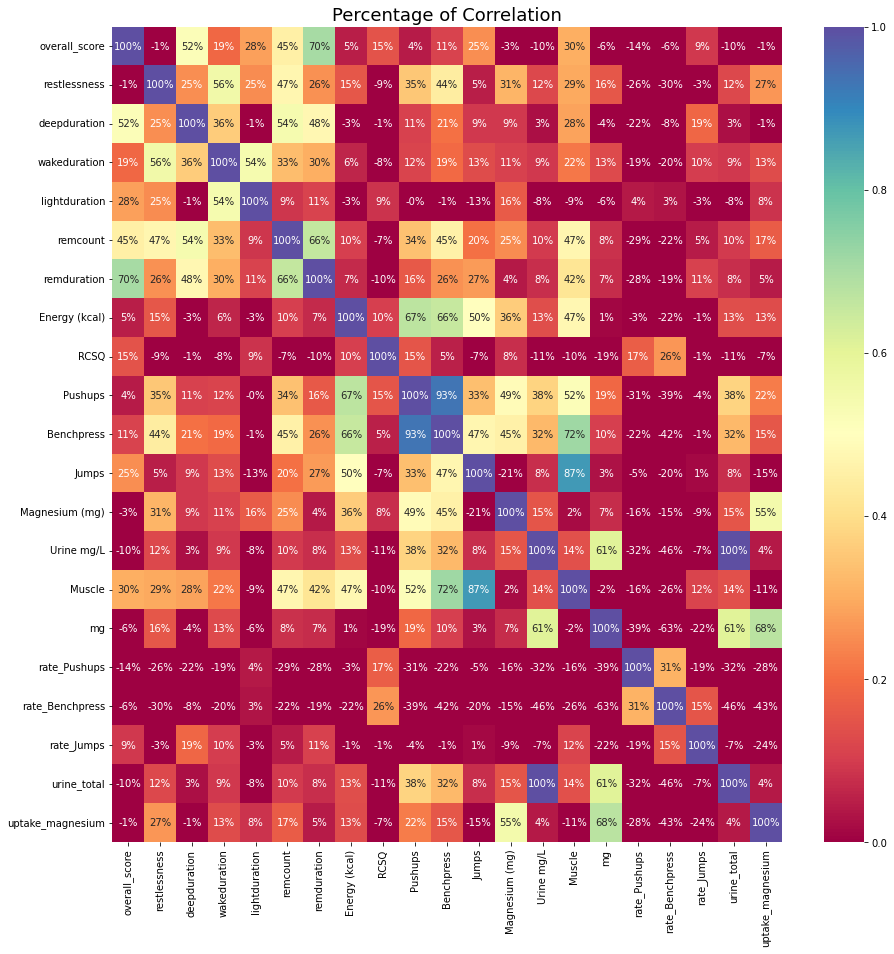

C:\Users\Hendrik\AppData\Local\Temp/ipykernel_16024/2363277806.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Hendrik\AppData\Local\Temp/ipykernel_16024/2814478125.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Hendrik\AppData\Local\Temp/ipykernel_16024/2814478125.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [128]:
""" #Amine
make a heatmap corrolation plot to show which variables are
correlated, to what degree and in which direction.
"""
plt.rcParams["figure.figsize"] = (15, 15)
plt.title('Percentage of Correlation', fontsize=18)
# cmap = sns.color_palette("mako", as_cmap=True)
cmap = sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(df_heatmap.corr(), annot = True, cmap=cmap, fmt='.0%', vmin=0, vmax=1)
plt.show()